In [9]:
# Experiment 3 KD with a smaller model as student

In [1]:
# Split the training data into validation set and training set use a stratified k fold 
import numpy as np
import pandas as pd
import sklearn

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import RobustScaler, QuantileTransformer 

from sklearn.model_selection import StratifiedKFold, KFold

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Knowledge distillation 
# Modified from source: https://keras.io/examples/vision/knowledge_distillation/

import Distiller

In [4]:
# Load the saved dataset
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html
california_housing_data_train = pd.read_csv('Data/california_housing_train.txt')
california_housing_data_test = pd.read_csv('Data/california_housing_test.txt')

# This dataset have strong outliers due to the hard limit of the housing price
# remove those from the training set
california_housing_data_train = california_housing_data_train[california_housing_data_train['MedHouseVal'] < 5]  


In [5]:
# Set up the datasets
x_train = california_housing_data_train.iloc[:,0:7].to_numpy()
y_train = california_housing_data_train.iloc[:,-1].to_numpy()

x_test = california_housing_data_test.iloc[:,0:7].to_numpy()
y_test = california_housing_data_test.iloc[:,-1].to_numpy()

In [6]:
# Build the student model

def buildStudentModel():
    model = models.Sequential()    
    model.add(layers.Dense(16, activation='relu'))
        
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1))    
    
    return model

In [7]:
# Construct/load models

teacher_model = tf.keras.models.load_model('MlpTeacherModel/MlpTeacherModel')

# Perform the 10 fold cross validation
number_of_folds = 10

skf = KFold(n_splits=number_of_folds)

In [8]:
# Haperparameter used in the experiment
number_of_epochs = 100

train_val_results_with_distillation = []
train_val_results_without_distillation = []

test_results_with_distillation = []
test_results_without_distillation = []

for i, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Fold {i}")
    
    studnet_model = buildStudentModel()
    studnet_model_without_distillation = keras.models.clone_model(studnet_model)
    
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
    distiller.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=['mse', 'mae', 'mape'],
        student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
        distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
        alpha=0.1,
        temperature=10        
    )
    # Distill teacher to student
    history = distiller.fit(
        x_train_fold, 
        y_train_fold, 
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_with_distillation.append(history.history)
    
    # Train and evaluate the student model without distillation
    studnet_model_without_distillation.compile(
        optimizer=keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=['mse', 'mae', 'mape'],
    )

    # Train and evaluate student trained from scratch.
    history = studnet_model_without_distillation.fit(
        x_train_fold, 
        y_train_fold,
        epochs=number_of_epochs,
        validation_data=(x_val_fold, y_val_fold)
    )
    train_val_results_without_distillation.append(history.history)
    
print('Training done')

Fold 0
Epoch 1/100
443/443 [==============================] - 2s 2ms/step - mse: 10739.3438 - mae: 38.7814 - mape: 2558.1965 - student_loss: 38.6334 - distillation_loss: 10691.8401 - val_mse: 13.8848 - val_mae: 2.4726 - val_mape: 149.9667 - val_student_loss: 2.8494
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 10.5829 - mae: 2.2113 - mape: 123.9814 - student_loss: 2.2101 - distillation_loss: 9.8648 - val_mse: 8.8620 - val_mae: 1.7897 - val_mape: 105.9498 - val_student_loss: 1.9417
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 6.4514 - mae: 1.5654 - mape: 88.4288 - student_loss: 1.5659 - distillation_loss: 5.8419 - val_mse: 5.6469 - val_mae: 1.3122 - val_mape: 84.5328 - val_student_loss: 1.5274
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 3.2760 - mae: 1.1495 - mape: 80.8399 - student_loss: 1.1503 - distillation_loss: 2.7650 - val_mse: 2.5450 - val_mae: 0.9646 - val_mape: 76.6720 - val_student_loss: 1.4

443/443 [==============================] - 1s 2ms/step - mse: 0.9735 - mae: 0.6559 - mape: 42.8913 - student_loss: 0.6550 - distillation_loss: 0.5496 - val_mse: 0.7196 - val_mae: 0.6850 - val_mape: 52.4587 - val_student_loss: 0.7800
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5896 - mae: 0.5769 - mape: 37.5119 - student_loss: 0.5755 - distillation_loss: 0.1616 - val_mse: 0.5073 - val_mae: 0.5514 - val_mape: 37.1288 - val_student_loss: 0.6379
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3845 - mae: 0.7125 - mape: 46.8614 - student_loss: 0.7122 - distillation_loss: 0.9636 - val_mse: 0.5995 - val_mae: 0.5477 - val_mape: 33.0903 - val_student_loss: 0.6469
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5993 - mae: 0.5762 - mape: 37.3694 - student_loss: 0.5753 - distillation_loss: 0.1711 - val_mse: 0.4927 - val_mae: 0.5410 - val_mape: 35.9456 - val_student_loss: 0.6040
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.6200 - mae: 0.5777 - mape: 37.3664 - student_loss: 0.5775 - distillation_loss: 0.1949 - val_mse: 0.5377 - val_mae: 0.5876 - val_mape: 42.0063 - val_student_loss: 0.6902
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5933 - mae: 0.5846 - mape: 37.4342 - student_loss: 0.5842 - distillation_loss: 0.1808 - val_mse: 0.5037 - val_mae: 0.5246 - val_mape: 30.5337 - val_student_loss: 0.5606
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5698 - mae: 0.5620 - mape: 36.0337 - student_loss: 0.5628 - distillation_loss: 0.1478 - val_mse: 0.4958 - val_mae: 0.5337 - val_mape: 32.8049 - val_student_loss: 0.6024
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4982 - mae: 0.5354 - mape: 34.2787 - student_loss: 0.5359 - distillation_loss: 0.0799 - val_mse: 0.4636 - val_mae: 0.5178 - val_mape: 32.9875 - val_student_loss: 0.5686
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 0.4526 - mae: 0.5076 - mape: 32.7273 - student_loss: 0.5079 - distillation_loss: 0.0529 - val_mse: 0.4247 - val_mae: 0.5058 - val_mape: 34.3042 - val_student_loss: 0.6879
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 19.3868 - mse: 4502.5928 - mae: 19.3868 - mape: 1281.5243 - val_loss: 0.8629 - val_mse: 17.3187 - val_mae: 0.8629 - val_mape: 56.4544
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7578 - mse: 10.0979 - mae: 0.7578 - mape: 47.8025 - val_loss: 1.6065 - val_mse: 10.8513 - val_mae: 1.6065 - val_mape: 95.8299
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7186 - mse: 3.1816 - mae: 0.7186 - mape: 44.3354 - val_loss: 0.6525 - val_mse: 2.8200 - val_mae: 0.6525 - val_mape: 37.6238
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6836 - mse: 1.6904 - mae: 0.6836 - mape: 42.0487 - val_loss: 0.8745 - val_mse

443/443 [==============================] - 1s 2ms/step - loss: 0.5777 - mse: 0.6735 - mae: 0.5777 - mape: 35.7346 - val_loss: 0.5182 - val_mse: 0.4965 - val_mae: 0.5182 - val_mape: 29.2768
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5637 - mse: 0.6280 - mae: 0.5637 - mape: 34.7534 - val_loss: 0.5109 - val_mse: 0.5124 - val_mae: 0.5109 - val_mape: 29.0148
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5528 - mse: 0.5706 - mae: 0.5528 - mape: 33.8689 - val_loss: 0.6338 - val_mse: 0.7940 - val_mae: 0.6338 - val_mape: 35.1258
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5695 - mse: 0.6528 - mae: 0.5695 - mape: 35.4248 - val_loss: 0.5225 - val_mse: 0.4667 - val_mae: 0.5225 - val_mape: 34.6313
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5782 - mse: 0.7328 - mae: 0.5782 - mape: 35.4840 - val_loss: 0.6979 - val_mse: 0.8460 - val_mae: 0.6979 - val_mape: 51.4274
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5328 - mse: 0.6106 - mae: 0.5328 - mape: 32.7260 - val_loss: 0.6323 - val_mse: 0.6297 - val_mae: 0.6323 - val_mape: 46.2926
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5514 - mse: 0.6312 - mae: 0.5514 - mape: 34.0305 - val_loss: 0.5450 - val_mse: 0.4838 - val_mae: 0.5450 - val_mape: 37.9169
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5366 - mse: 0.5496 - mae: 0.5366 - mape: 33.0091 - val_loss: 0.5984 - val_mse: 0.6546 - val_mae: 0.5984 - val_mape: 33.1158
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5334 - mse: 0.5694 - mae: 0.5334 - mape: 32.8072 - val_loss: 0.5033 - val_mse: 0.4339 - val_mae: 0.5033 - val_mape: 33.1436
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5834 - mse: 0.6447 - mae: 0.5834 - mape: 36.3634 - val_loss: 0.6036 - val_mse: 0.5821 - val_mae: 0.6036 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 5.7115 - mae: 1.1415 - mape: 74.7384 - student_loss: 1.1382 - distillation_loss: 5.2919 - val_mse: 0.6047 - val_mae: 0.5826 - val_mape: 37.9918 - val_student_loss: 0.3543
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7797 - mae: 0.6257 - mape: 40.5466 - student_loss: 0.6259 - distillation_loss: 0.3619 - val_mse: 0.5051 - val_mae: 0.5346 - val_mape: 33.4075 - val_student_loss: 0.4132
Epoch 20/100
443/443 [==============================] - 1s 3ms/step - mse: 0.7557 - mae: 0.6120 - mape: 39.4921 - student_loss: 0.6114 - distillation_loss: 0.3586 - val_mse: 0.5601 - val_mae: 0.5873 - val_mape: 41.4054 - val_student_loss: 0.5888
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 1.7030 - mae: 0.7725 - mape: 50.7212 - student_loss: 0.7735 - distillation_loss: 1.3052 - val_mse: 4.4743 - val_mae: 1.6358 - val_mape: 92.8645 - val_student_loss: 0.9733
Epoch 22/100
443

443/443 [==============================] - 1s 3ms/step - mse: 1.2705 - mae: 0.6882 - mape: 44.5423 - student_loss: 0.6880 - distillation_loss: 0.8748 - val_mse: 16.7508 - val_mae: 2.9996 - val_mape: 210.2207 - val_student_loss: 2.7058
Epoch 52/100
443/443 [==============================] - 1s 3ms/step - mse: 1.3646 - mae: 0.7960 - mape: 52.0871 - student_loss: 0.7965 - distillation_loss: 0.9491 - val_mse: 0.6416 - val_mae: 0.6084 - val_mape: 41.8739 - val_student_loss: 0.4798
Epoch 53/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9808 - mae: 0.7185 - mape: 46.5565 - student_loss: 0.7194 - distillation_loss: 0.5885 - val_mse: 0.8044 - val_mae: 0.6569 - val_mape: 45.2462 - val_student_loss: 0.4909
Epoch 54/100
443/443 [==============================] - 1s 3ms/step - mse: 1.2772 - mae: 0.7497 - mape: 48.5733 - student_loss: 0.7576 - distillation_loss: 0.9311 - val_mse: 9.3301 - val_mae: 2.3922 - val_mape: 171.7471 - val_student_loss: 2.3694
Epoch 55/100
443/443 [====

443/443 [==============================] - 1s 3ms/step - mse: 0.6321 - mae: 0.6010 - mape: 38.9272 - student_loss: 0.6020 - distillation_loss: 0.2159 - val_mse: 0.8635 - val_mae: 0.7277 - val_mape: 53.4571 - val_student_loss: 0.7446
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 1.1257 - mae: 0.7179 - mape: 46.8006 - student_loss: 0.7186 - distillation_loss: 0.7374 - val_mse: 1.3620 - val_mae: 0.8345 - val_mape: 43.4027 - val_student_loss: 0.3141
Epoch 86/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9665 - mae: 0.6647 - mape: 43.1720 - student_loss: 0.6641 - distillation_loss: 0.5500 - val_mse: 0.6765 - val_mae: 0.6006 - val_mape: 31.2440 - val_student_loss: 0.2940
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6612 - mae: 0.6067 - mape: 39.0028 - student_loss: 0.6062 - distillation_loss: 0.2524 - val_mse: 2.1832 - val_mae: 1.1071 - val_mape: 81.8804 - val_student_loss: 1.1181
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6357 - mse: 0.7898 - mae: 0.6357 - mape: 39.5262 - val_loss: 0.5333 - val_mse: 0.5084 - val_mae: 0.5333 - val_mape: 33.0250
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5742 - mse: 0.6270 - mae: 0.5742 - mape: 34.9247 - val_loss: 0.5238 - val_mse: 0.5038 - val_mae: 0.5238 - val_mape: 30.0607
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6222 - mse: 0.7673 - mae: 0.6222 - mape: 38.4335 - val_loss: 0.5246 - val_mse: 0.5023 - val_mae: 0.5246 - val_mape: 30.4575
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6073 - mse: 0.6901 - mae: 0.6073 - mape: 37.5413 - val_loss: 0.6073 - val_mse: 0.6855 - val_mae: 0.6073 - val_mape: 32.0181
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6084 - mse: 0.6794 - mae: 0.6084 - mape: 37.3209 - val_loss: 0.6476 - val_mse: 0.7538 - val_mae: 0.6476 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5722 - mse: 0.6509 - mae: 0.5722 - mape: 35.2978 - val_loss: 0.5854 - val_mse: 0.7011 - val_mae: 0.5854 - val_mape: 31.2092
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5744 - mse: 0.6233 - mae: 0.5744 - mape: 35.5252 - val_loss: 0.5019 - val_mse: 0.4990 - val_mae: 0.5019 - val_mape: 30.7955
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5515 - mse: 0.6209 - mae: 0.5515 - mape: 33.9505 - val_loss: 0.5842 - val_mse: 0.6118 - val_mae: 0.5842 - val_mape: 40.5623
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5472 - mse: 0.6196 - mae: 0.5472 - mape: 33.7937 - val_loss: 0.5178 - val_mse: 0.4701 - val_mae: 0.5178 - val_mape: 34.3223
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5554 - mse: 0.6387 - mae: 0.5554 - mape: 34.2007 - val_loss: 0.9014 - val_mse: 1.4628 - val_mae: 0.9014 - val_mape: 65.3586
Epo

443/443 [==============================] - 2s 3ms/step - mse: 92340.6719 - mae: 174.1581 - mape: 11585.8760 - student_loss: 173.5364 - distillation_loss: 91955.7673 - val_mse: 1223.4954 - val_mae: 23.3293 - val_mape: 1592.6051 - val_student_loss: 17.5971
Epoch 2/100
443/443 [==============================] - 1s 3ms/step - mse: 336.9647 - mae: 9.7142 - mape: 639.8220 - student_loss: 9.6987 - distillation_loss: 334.4008 - val_mse: 34.5127 - val_mae: 3.2676 - val_mape: 205.0521 - val_student_loss: 1.6582
Epoch 3/100
443/443 [==============================] - 1s 3ms/step - mse: 14.6860 - mae: 2.2334 - mape: 125.6931 - student_loss: 2.2260 - distillation_loss: 13.9821 - val_mse: 3.6425 - val_mae: 1.0955 - val_mape: 74.0298 - val_student_loss: 0.8265
Epoch 4/100
443/443 [==============================] - 1s 3ms/step - mse: 3.8190 - mae: 1.2631 - mape: 67.4087 - student_loss: 1.2620 - distillation_loss: 3.3047 - val_mse: 1.7395 - val_mae: 0.9426 - val_mape: 57.0507 - val_student_loss: 1.0245


443/443 [==============================] - 1s 3ms/step - mse: 0.5927 - mae: 0.5759 - mape: 37.5962 - student_loss: 0.5760 - distillation_loss: 0.1848 - val_mse: 0.4959 - val_mae: 0.5545 - val_mape: 39.2691 - val_student_loss: 0.4999
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5217 - mae: 0.5449 - mape: 35.4877 - student_loss: 0.5444 - distillation_loss: 0.1216 - val_mse: 0.4784 - val_mae: 0.5343 - val_mape: 36.9792 - val_student_loss: 0.4689
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4945 - mae: 0.5354 - mape: 35.0710 - student_loss: 0.5344 - distillation_loss: 0.0902 - val_mse: 0.4630 - val_mae: 0.5094 - val_mape: 32.8607 - val_student_loss: 0.4750
Epoch 37/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5038 - mae: 0.5375 - mape: 34.7962 - student_loss: 0.5376 - distillation_loss: 0.1042 - val_mse: 0.4739 - val_mae: 0.5229 - val_mape: 35.3032 - val_student_loss: 0.4537
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4412 - mae: 0.5147 - mape: 35.7940 - student_loss: 0.5148 - distillation_loss: 0.0550 - val_mse: 0.4330 - val_mae: 0.5023 - val_mape: 34.3129 - val_student_loss: 0.5423
Epoch 68/100
443/443 [==============================] - 1s 3ms/step - mse: 0.4542 - mae: 0.5168 - mape: 34.9130 - student_loss: 0.5173 - distillation_loss: 0.0704 - val_mse: 0.4728 - val_mae: 0.5504 - val_mape: 39.8173 - val_student_loss: 0.5260
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4417 - mae: 0.5106 - mape: 34.2986 - student_loss: 0.5105 - distillation_loss: 0.0553 - val_mse: 0.7604 - val_mae: 0.6512 - val_mape: 36.1298 - val_student_loss: 0.5356
Epoch 70/100
443/443 [==============================] - 1s 3ms/step - mse: 0.4494 - mae: 0.5142 - mape: 34.2790 - student_loss: 0.5142 - distillation_loss: 0.0631 - val_mse: 0.4498 - val_mae: 0.5325 - val_mape: 37.5475 - val_student_loss: 0.5093
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4087 - mae: 0.4838 - mape: 31.4773 - student_loss: 0.4838 - distillation_loss: 0.0253 - val_mse: 0.4145 - val_mae: 0.4992 - val_mape: 34.0128 - val_student_loss: 0.4726
Epoch 1/100
443/443 [==============================] - 1s 3ms/step - loss: 79.0636 - mse: 56340.5781 - mae: 79.0636 - mape: 5105.2212 - val_loss: 0.7164 - val_mse: 1.0406 - val_mae: 0.7164 - val_mape: 42.3154
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8366 - mse: 2.3852 - mae: 0.8366 - mape: 52.6862 - val_loss: 0.6439 - val_mse: 0.7020 - val_mae: 0.6439 - val_mape: 44.1294
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7369 - mse: 1.0453 - mae: 0.7369 - mape: 46.1675 - val_loss: 0.5919 - val_mse: 0.6877 - val_mae: 0.5919 - val_mape: 32.7433
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7457 - mse: 1.0719 - mae: 0.7457 - mape: 46.5398 - val_loss: 0.8429 - val_mse: 

443/443 [==============================] - 1s 2ms/step - loss: 0.6214 - mse: 0.7083 - mae: 0.6214 - mape: 39.2284 - val_loss: 1.0899 - val_mse: 1.9583 - val_mae: 1.0899 - val_mape: 62.5027
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6983 - mse: 0.9364 - mae: 0.6983 - mape: 44.2628 - val_loss: 0.4982 - val_mse: 0.4765 - val_mae: 0.4982 - val_mape: 29.5700
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6324 - mse: 0.7406 - mae: 0.6324 - mape: 40.0676 - val_loss: 0.8317 - val_mse: 1.1030 - val_mae: 0.8317 - val_mape: 61.7046
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6681 - mse: 0.8363 - mae: 0.6681 - mape: 42.5265 - val_loss: 0.5047 - val_mse: 0.4897 - val_mae: 0.5047 - val_mape: 29.0041
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6172 - mse: 0.7282 - mae: 0.6172 - mape: 38.8886 - val_loss: 0.5876 - val_mse: 0.5632 - val_mae: 0.5876 - val_mape: 41.1835
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5980 - mse: 0.6607 - mae: 0.5980 - mape: 37.3384 - val_loss: 0.4962 - val_mse: 0.4406 - val_mae: 0.4962 - val_mape: 31.3754
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6326 - mse: 0.7370 - mae: 0.6326 - mape: 39.8072 - val_loss: 0.4947 - val_mse: 0.4679 - val_mae: 0.4947 - val_mape: 28.8286
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6182 - mse: 0.7227 - mae: 0.6182 - mape: 38.6605 - val_loss: 0.5551 - val_mse: 0.5656 - val_mae: 0.5551 - val_mape: 31.0229
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5880 - mse: 0.6968 - mae: 0.5880 - mape: 37.0016 - val_loss: 0.5094 - val_mse: 0.4411 - val_mae: 0.5094 - val_mape: 33.9957
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6099 - mse: 0.6886 - mae: 0.6099 - mape: 38.4298 - val_loss: 0.4926 - val_mse: 0.4364 - val_mae: 0.4926 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6998 - mae: 0.6287 - mape: 41.2369 - student_loss: 0.6277 - distillation_loss: 0.2788 - val_mse: 0.5790 - val_mae: 0.5579 - val_mape: 36.1144 - val_student_loss: 0.3856
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6798 - mae: 0.6033 - mape: 39.2564 - student_loss: 0.6020 - distillation_loss: 0.2671 - val_mse: 0.5628 - val_mae: 0.5690 - val_mape: 39.3841 - val_student_loss: 0.4839
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 10.0916 - mae: 1.2475 - mape: 82.1764 - student_loss: 1.2441 - distillation_loss: 9.6254 - val_mse: 0.7032 - val_mae: 0.5978 - val_mape: 34.1634 - val_student_loss: 0.2610
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 1.8835 - mae: 0.8423 - mape: 54.6831 - student_loss: 0.8396 - distillation_loss: 1.4403 - val_mse: 0.9715 - val_mae: 0.7088 - val_mape: 38.0868 - val_student_loss: 0.3166
Epoch 22/100
44

443/443 [==============================] - 1s 2ms/step - mse: 1.2805 - mae: 0.7154 - mape: 45.8228 - student_loss: 0.7148 - distillation_loss: 0.8700 - val_mse: 0.5364 - val_mae: 0.5625 - val_mape: 38.1780 - val_student_loss: 0.3851
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 4.7937 - mae: 1.2496 - mape: 81.7887 - student_loss: 1.2464 - distillation_loss: 4.3535 - val_mse: 0.5234 - val_mae: 0.5481 - val_mape: 36.4789 - val_student_loss: 0.3357
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6654 - mae: 0.5887 - mape: 37.8639 - student_loss: 0.5909 - distillation_loss: 0.2667 - val_mse: 1.2075 - val_mae: 0.9100 - val_mape: 70.9429 - val_student_loss: 0.8925
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0453 - mae: 0.6944 - mape: 44.8869 - student_loss: 0.6939 - distillation_loss: 0.6274 - val_mse: 0.5284 - val_mae: 0.5654 - val_mape: 38.6559 - val_student_loss: 0.4843
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 2.1485 - mae: 0.8946 - mape: 58.6451 - student_loss: 0.8925 - distillation_loss: 1.7398 - val_mse: 0.5185 - val_mae: 0.5340 - val_mape: 34.1626 - val_student_loss: 0.2961
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 1.8716 - mae: 0.8726 - mape: 56.3979 - student_loss: 0.8707 - distillation_loss: 1.4466 - val_mse: 0.7470 - val_mae: 0.6997 - val_mape: 51.9251 - val_student_loss: 0.6643
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6672 - mae: 0.6074 - mape: 39.0059 - student_loss: 0.6068 - distillation_loss: 0.2539 - val_mse: 0.5131 - val_mae: 0.5314 - val_mape: 33.4289 - val_student_loss: 0.3598
Epoch 87/100
443/443 [==============================] - 1s 3ms/step - mse: 2.7802 - mae: 1.0015 - mape: 64.9041 - student_loss: 1.0036 - distillation_loss: 2.3793 - val_mse: 3.6467 - val_mae: 1.5512 - val_mape: 118.1684 - val_student_loss: 1.5237
Epoch 88/100
443/443 [======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7640 - mse: 1.1181 - mae: 0.7640 - mape: 48.5089 - val_loss: 1.0655 - val_mse: 1.8062 - val_mae: 1.0655 - val_mape: 81.9587
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7874 - mse: 1.2139 - mae: 0.7874 - mape: 49.7663 - val_loss: 0.7284 - val_mse: 0.9775 - val_mae: 0.7284 - val_mape: 39.5686
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7196 - mse: 1.0375 - mae: 0.7196 - mape: 45.2350 - val_loss: 1.7285 - val_mse: 5.1757 - val_mae: 1.7285 - val_mape: 129.6829
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7864 - mse: 1.2173 - mae: 0.7864 - mape: 49.5184 - val_loss: 0.5572 - val_mse: 0.5477 - val_mae: 0.5572 - val_mape: 37.5351
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7510 - mse: 1.1248 - mae: 0.7510 - mape: 47.7112 - val_loss: 0.6097 - val_mse: 0.6058 - val_mae: 0.6097 - val_map

443/443 [==============================] - 1s 2ms/step - loss: 0.6610 - mse: 0.8378 - mae: 0.6610 - mape: 41.2112 - val_loss: 0.7642 - val_mse: 0.8918 - val_mae: 0.7642 - val_mape: 58.1033
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6846 - mse: 0.9090 - mae: 0.6846 - mape: 42.8501 - val_loss: 0.9791 - val_mse: 1.4968 - val_mae: 0.9791 - val_mape: 75.2691
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7262 - mse: 1.0643 - mae: 0.7262 - mape: 46.1879 - val_loss: 0.8610 - val_mse: 1.2896 - val_mae: 0.8610 - val_mape: 47.8665
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7028 - mse: 0.9105 - mae: 0.7028 - mape: 44.0142 - val_loss: 0.5703 - val_mse: 0.6250 - val_mae: 0.5703 - val_mape: 32.7128
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7271 - mse: 1.0297 - mae: 0.7271 - mape: 45.9330 - val_loss: 0.6823 - val_mse: 0.8498 - val_mae: 0.6823 - val_mape: 37.9474
Epo

443/443 [==============================] - 2s 3ms/step - mse: 188.6061 - mae: 4.8380 - mape: 316.5830 - student_loss: 4.8235 - distillation_loss: 187.2343 - val_mse: 1.6154 - val_mae: 0.9776 - val_mape: 67.4718 - val_student_loss: 0.7857
Epoch 2/100
443/443 [==============================] - 1s 3ms/step - mse: 1.2550 - mae: 0.8505 - mape: 57.0093 - student_loss: 0.8496 - distillation_loss: 0.8270 - val_mse: 0.8934 - val_mae: 0.7495 - val_mape: 54.8612 - val_student_loss: 0.4855
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7957 - mae: 0.6840 - mape: 47.1488 - student_loss: 0.6847 - distillation_loss: 0.3581 - val_mse: 0.6991 - val_mae: 0.6488 - val_mape: 45.6397 - val_student_loss: 0.4486
Epoch 4/100
443/443 [==============================] - 1s 3ms/step - mse: 0.7403 - mae: 0.6612 - mape: 45.0962 - student_loss: 0.6610 - distillation_loss: 0.3018 - val_mse: 0.6368 - val_mae: 0.6080 - val_mape: 40.6635 - val_student_loss: 0.4628
Epoch 5/100
443/443 [======

443/443 [==============================] - 1s 3ms/step - mse: 0.8259 - mae: 0.6168 - mape: 39.8582 - student_loss: 0.6164 - distillation_loss: 0.4227 - val_mse: 3.0021 - val_mae: 1.4831 - val_mape: 111.6328 - val_student_loss: 0.9193
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7841 - mae: 0.6346 - mape: 41.3439 - student_loss: 0.6350 - distillation_loss: 0.3691 - val_mse: 0.5161 - val_mae: 0.5314 - val_mape: 30.3299 - val_student_loss: 0.5265
Epoch 36/100
443/443 [==============================] - 1s 3ms/step - mse: 0.8067 - mae: 0.6302 - mape: 41.0429 - student_loss: 0.6309 - distillation_loss: 0.3897 - val_mse: 0.5430 - val_mae: 0.5886 - val_mape: 41.0701 - val_student_loss: 0.4280
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8553 - mae: 0.6587 - mape: 42.8500 - student_loss: 0.6577 - distillation_loss: 0.4348 - val_mse: 0.4816 - val_mae: 0.5292 - val_mape: 34.1089 - val_student_loss: 0.4657
Epoch 38/100
443/443 [======

443/443 [==============================] - 1s 2ms/step - mse: 0.6460 - mae: 0.6058 - mape: 39.3248 - student_loss: 0.6063 - distillation_loss: 0.2382 - val_mse: 0.7579 - val_mae: 0.6470 - val_mape: 33.1424 - val_student_loss: 0.6104
Epoch 68/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5320 - mae: 0.5535 - mape: 35.6896 - student_loss: 0.5550 - distillation_loss: 0.1236 - val_mse: 0.4740 - val_mae: 0.5146 - val_mape: 31.4119 - val_student_loss: 0.5157
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6097 - mae: 0.5742 - mape: 37.1563 - student_loss: 0.5732 - distillation_loss: 0.2004 - val_mse: 0.8129 - val_mae: 0.6714 - val_mape: 34.8215 - val_student_loss: 0.6237
Epoch 70/100
443/443 [==============================] - 1s 3ms/step - mse: 0.8721 - mae: 0.6370 - mape: 41.2713 - student_loss: 0.6361 - distillation_loss: 0.4548 - val_mse: 0.4769 - val_mae: 0.5222 - val_mape: 32.9417 - val_student_loss: 0.4783
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.5310 - mae: 0.5506 - mape: 35.3858 - student_loss: 0.5503 - distillation_loss: 0.1215 - val_mse: 0.6061 - val_mae: 0.6238 - val_mape: 43.7520 - val_student_loss: 0.4432
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 8.5068 - mse: 821.1682 - mae: 8.5068 - mape: 549.1380 - val_loss: 1.0398 - val_mse: 1.6391 - val_mae: 1.0398 - val_mape: 83.3504
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8547 - mse: 3.4767 - mae: 0.8547 - mape: 58.4539 - val_loss: 0.7682 - val_mse: 0.9812 - val_mae: 0.7682 - val_mape: 41.0313
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7478 - mse: 1.9899 - mae: 0.7478 - mape: 50.0101 - val_loss: 0.6137 - val_mse: 0.6208 - val_mae: 0.6137 - val_mape: 43.2954
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7399 - mse: 1.4260 - mae: 0.7399 - mape: 48.3583 - val_loss: 0.6384 - val_mse: 0.715

443/443 [==============================] - 1s 2ms/step - loss: 0.5505 - mse: 0.5712 - mae: 0.5505 - mape: 33.9548 - val_loss: 0.6198 - val_mse: 0.6815 - val_mae: 0.6198 - val_mape: 33.1123
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5500 - mse: 0.5498 - mae: 0.5500 - mape: 34.2807 - val_loss: 0.6745 - val_mse: 0.7203 - val_mae: 0.6745 - val_mape: 47.6744
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5490 - mse: 0.5735 - mae: 0.5490 - mape: 33.7862 - val_loss: 0.5455 - val_mse: 0.4915 - val_mae: 0.5455 - val_mape: 36.4975
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5535 - mse: 0.5618 - mae: 0.5535 - mape: 34.4861 - val_loss: 0.5319 - val_mse: 0.4714 - val_mae: 0.5319 - val_mape: 35.3986
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5372 - mse: 0.5341 - mae: 0.5372 - mape: 32.9840 - val_loss: 0.6312 - val_mse: 0.6986 - val_mae: 0.6312 - val_mape: 32.8205
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5044 - mse: 0.4702 - mae: 0.5044 - mape: 30.8964 - val_loss: 0.5019 - val_mse: 0.4613 - val_mae: 0.5019 - val_mape: 28.2227
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4903 - mse: 0.4401 - mae: 0.4903 - mape: 29.9207 - val_loss: 0.4672 - val_mse: 0.4028 - val_mae: 0.4672 - val_mape: 28.0731
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5033 - mse: 0.4615 - mae: 0.5033 - mape: 30.6300 - val_loss: 0.5483 - val_mse: 0.4727 - val_mae: 0.5483 - val_mape: 38.7365
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4915 - mse: 0.4410 - mae: 0.4915 - mape: 30.1893 - val_loss: 0.4684 - val_mse: 0.3996 - val_mae: 0.4684 - val_mape: 28.4104
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4938 - mse: 0.4431 - mae: 0.4938 - mape: 30.0390 - val_loss: 0.5049 - val_mse: 0.4648 - val_mae: 0.5049 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 2.2322 - mae: 0.8841 - mape: 58.5974 - student_loss: 0.8835 - distillation_loss: 1.8065 - val_mse: 0.7345 - val_mae: 0.5644 - val_mape: 37.7465 - val_student_loss: 0.7458
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7430 - mae: 0.6352 - mape: 41.3199 - student_loss: 0.6340 - distillation_loss: 0.3252 - val_mse: 1.0722 - val_mae: 0.8176 - val_mape: 60.7797 - val_student_loss: 0.9286
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 1.2097 - mae: 0.7496 - mape: 48.5815 - student_loss: 0.7495 - distillation_loss: 0.8008 - val_mse: 1.0858 - val_mae: 0.8563 - val_mape: 64.1424 - val_student_loss: 0.9671
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 1.4183 - mae: 0.7944 - mape: 51.8723 - student_loss: 0.7932 - distillation_loss: 0.9883 - val_mse: 1.1440 - val_mae: 0.8876 - val_mape: 67.2619 - val_student_loss: 0.9743
Epoch 22/100
443

443/443 [==============================] - 1s 2ms/step - mse: 0.8088 - mae: 0.7099 - mape: 50.2200 - student_loss: 0.7120 - distillation_loss: 0.3790 - val_mse: 6.0672 - val_mae: 1.9775 - val_mape: 150.7384 - val_student_loss: 1.6390
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0535 - mae: 0.7411 - mape: 50.6277 - student_loss: 0.7399 - distillation_loss: 0.6290 - val_mse: 0.9070 - val_mae: 0.7849 - val_mape: 60.5732 - val_student_loss: 0.8230
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9825 - mae: 0.6998 - mape: 47.5796 - student_loss: 0.6982 - distillation_loss: 0.5631 - val_mse: 0.6074 - val_mae: 0.5800 - val_mape: 35.9633 - val_student_loss: 0.8346
Epoch 54/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8269 - mae: 0.6804 - mape: 45.6162 - student_loss: 0.6806 - distillation_loss: 0.4008 - val_mse: 0.5639 - val_mae: 0.5516 - val_mape: 34.2675 - val_student_loss: 0.7461
Epoch 55/100
443/443 [======

443/443 [==============================] - 1s 2ms/step - mse: 0.9302 - mae: 0.6559 - mape: 42.4229 - student_loss: 0.6555 - distillation_loss: 0.5158 - val_mse: 1.2231 - val_mae: 0.8176 - val_mape: 44.8876 - val_student_loss: 1.3362
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5662 - mae: 0.5695 - mape: 37.1639 - student_loss: 0.5699 - distillation_loss: 0.1492 - val_mse: 0.4989 - val_mae: 0.5211 - val_mape: 32.8491 - val_student_loss: 0.7012
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6199 - mae: 0.5802 - mape: 37.7460 - student_loss: 0.5816 - distillation_loss: 0.2012 - val_mse: 0.4988 - val_mae: 0.5345 - val_mape: 35.7526 - val_student_loss: 0.6973
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7381 - mae: 0.6206 - mape: 40.4605 - student_loss: 0.6205 - distillation_loss: 0.3254 - val_mse: 0.5189 - val_mae: 0.5379 - val_mape: 35.7501 - val_student_loss: 0.6817
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5636 - mse: 0.5677 - mae: 0.5636 - mape: 35.1892 - val_loss: 0.5188 - val_mse: 0.5010 - val_mae: 0.5188 - val_mape: 31.1193
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5679 - mse: 0.5772 - mae: 0.5679 - mape: 35.2845 - val_loss: 0.5902 - val_mse: 0.5682 - val_mae: 0.5902 - val_mape: 41.3224
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5687 - mse: 0.5747 - mae: 0.5687 - mape: 35.5531 - val_loss: 0.5194 - val_mse: 0.5044 - val_mae: 0.5194 - val_mape: 30.7534
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5807 - mse: 0.6004 - mae: 0.5807 - mape: 36.3472 - val_loss: 0.6565 - val_mse: 0.6960 - val_mae: 0.6565 - val_mape: 47.0487
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5626 - mse: 0.5606 - mae: 0.5626 - mape: 35.0125 - val_loss: 0.5922 - val_mse: 0.5643 - val_mae: 0.5922 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.5037 - mse: 0.4712 - mae: 0.5037 - mape: 30.7173 - val_loss: 0.4995 - val_mse: 0.4309 - val_mae: 0.4995 - val_mape: 32.8681
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.4991 - mse: 0.4512 - mae: 0.4991 - mape: 30.4104 - val_loss: 0.4916 - val_mse: 0.4257 - val_mae: 0.4916 - val_mape: 31.5375
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5082 - mse: 0.4647 - mae: 0.5082 - mape: 30.8136 - val_loss: 0.4847 - val_mse: 0.4291 - val_mae: 0.4847 - val_mape: 30.1829
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5018 - mse: 0.4599 - mae: 0.5018 - mape: 30.5703 - val_loss: 0.4957 - val_mse: 0.4590 - val_mae: 0.4957 - val_mape: 29.0382
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5079 - mse: 0.4677 - mae: 0.5079 - mape: 30.8319 - val_loss: 0.5005 - val_mse: 0.4299 - val_mae: 0.5005 - val_mape: 33.1169
Epo

443/443 [==============================] - 1s 3ms/step - mse: 127.6339 - mae: 3.9740 - mape: 269.6576 - student_loss: 3.9660 - distillation_loss: 126.9183 - val_mse: 4.0720 - val_mae: 1.5905 - val_mape: 106.1492 - val_student_loss: 3.1696
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - mse: 8.0812 - mae: 1.4452 - mape: 95.3936 - student_loss: 1.4449 - distillation_loss: 7.7068 - val_mse: 1.2737 - val_mae: 0.8566 - val_mape: 53.0723 - val_student_loss: 2.1993
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 4.1544 - mae: 1.0116 - mape: 66.0201 - student_loss: 1.0110 - distillation_loss: 3.7881 - val_mse: 0.8270 - val_mae: 0.6901 - val_mape: 45.1022 - val_student_loss: 1.5211
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3115 - mae: 0.7569 - mape: 49.5166 - student_loss: 0.7559 - distillation_loss: 0.8836 - val_mse: 0.7387 - val_mae: 0.6660 - val_mape: 44.6206 - val_student_loss: 1.2887
Epoch 5/100
443/443 [=====

443/443 [==============================] - 1s 2ms/step - mse: 1.3754 - mae: 0.8039 - mape: 52.6084 - student_loss: 0.8030 - distillation_loss: 0.9659 - val_mse: 0.5633 - val_mae: 0.5932 - val_mape: 40.3751 - val_student_loss: 0.7529
Epoch 35/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6325 - mae: 0.5932 - mape: 38.3835 - student_loss: 0.5928 - distillation_loss: 0.2221 - val_mse: 0.5158 - val_mae: 0.5444 - val_mape: 34.5984 - val_student_loss: 0.8735
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0260 - mae: 0.7023 - mape: 45.5647 - student_loss: 0.7023 - distillation_loss: 0.6287 - val_mse: 0.8097 - val_mae: 0.6490 - val_mape: 34.0924 - val_student_loss: 1.5204
Epoch 37/100
443/443 [==============================] - 1s 2ms/step - mse: 1.3581 - mae: 0.7340 - mape: 47.7258 - student_loss: 0.7489 - distillation_loss: 1.0332 - val_mse: 1.6538 - val_mae: 1.0748 - val_mape: 57.4172 - val_student_loss: 2.0989
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.6748 - mae: 0.6143 - mape: 39.5742 - student_loss: 0.6138 - distillation_loss: 0.2767 - val_mse: 0.5405 - val_mae: 0.5805 - val_mape: 39.7415 - val_student_loss: 0.6932
Epoch 68/100
443/443 [==============================] - 1s 2ms/step - mse: 0.9163 - mae: 0.6532 - mape: 42.4779 - student_loss: 0.6526 - distillation_loss: 0.5109 - val_mse: 0.8078 - val_mae: 0.6524 - val_mape: 33.4336 - val_student_loss: 1.5366
Epoch 69/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6736 - mae: 0.6002 - mape: 38.7691 - student_loss: 0.6013 - distillation_loss: 0.2685 - val_mse: 2.4504 - val_mae: 1.2305 - val_mape: 88.2051 - val_student_loss: 0.4569
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6784 - mae: 0.6006 - mape: 38.7621 - student_loss: 0.5995 - distillation_loss: 0.2788 - val_mse: 0.5319 - val_mae: 0.5287 - val_mape: 29.8362 - val_student_loss: 1.0718
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.6148 - mae: 0.5919 - mape: 38.7183 - student_loss: 0.5918 - distillation_loss: 0.2095 - val_mse: 0.4968 - val_mae: 0.5275 - val_mape: 33.3413 - val_student_loss: 1.1693
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 5.8265 - mse: 221.1948 - mae: 5.8265 - mape: 395.6230 - val_loss: 2.2383 - val_mse: 7.8899 - val_mae: 2.2383 - val_mape: 139.3648
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 1.6630 - mse: 8.1215 - mae: 1.6630 - mape: 110.1525 - val_loss: 0.9678 - val_mse: 1.5946 - val_mae: 0.9678 - val_mape: 54.2698
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 1.2906 - mse: 4.1820 - mae: 1.2906 - mape: 83.8890 - val_loss: 1.1522 - val_mse: 2.4116 - val_mae: 1.1522 - val_mape: 64.1200
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 1.3810 - mse: 4.6861 - mae: 1.3810 - mape: 90.0455 - val_loss: 1.7098 - val_mse: 4.5

443/443 [==============================] - 1s 2ms/step - loss: 1.1830 - mse: 3.3047 - mae: 1.1830 - mape: 77.5889 - val_loss: 1.2665 - val_mse: 2.3425 - val_mae: 1.2665 - val_mape: 91.1590
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0042 - mse: 2.2190 - mae: 1.0042 - mape: 64.7564 - val_loss: 0.6495 - val_mse: 0.7992 - val_mae: 0.6495 - val_mape: 34.3997
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9484 - mse: 2.1290 - mae: 0.9484 - mape: 61.3314 - val_loss: 0.8329 - val_mse: 1.1111 - val_mae: 0.8329 - val_mape: 58.4617
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9523 - mse: 2.0822 - mae: 0.9523 - mape: 61.8347 - val_loss: 0.6350 - val_mse: 0.6607 - val_mae: 0.6350 - val_mape: 43.3599
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8860 - mse: 1.6332 - mae: 0.8860 - mape: 57.2830 - val_loss: 0.9788 - val_mse: 1.7841 - val_mae: 0.9788 - val_mape: 53.5002
Epo

443/443 [==============================] - 1s 2ms/step - loss: 0.7747 - mse: 1.2494 - mae: 0.7747 - mape: 49.4144 - val_loss: 0.6724 - val_mse: 0.7831 - val_mae: 0.6724 - val_mape: 46.1361
Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6990 - mse: 0.9244 - mae: 0.6990 - mape: 44.0440 - val_loss: 0.7929 - val_mse: 0.9731 - val_mae: 0.7929 - val_mape: 56.2445
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7896 - mse: 1.3317 - mae: 0.7896 - mape: 50.5395 - val_loss: 0.5155 - val_mse: 0.4908 - val_mae: 0.5155 - val_mape: 32.0299
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6950 - mse: 0.9958 - mae: 0.6950 - mape: 43.8539 - val_loss: 0.5750 - val_mse: 0.5477 - val_mae: 0.5750 - val_mape: 38.4076
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7525 - mse: 1.1323 - mae: 0.7525 - mape: 47.9814 - val_loss: 0.8474 - val_mse: 1.2787 - val_mae: 0.8474 - val_mape: 44.9200
Epo

443/443 [==============================] - 1s 2ms/step - mse: 0.6631 - mae: 0.6379 - mape: 44.7561 - student_loss: 0.6416 - distillation_loss: 0.2299 - val_mse: 2.4510 - val_mae: 1.2991 - val_mape: 104.0813 - val_student_loss: 0.7148
Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6481 - mae: 0.6279 - mape: 43.5348 - student_loss: 0.6281 - distillation_loss: 0.2120 - val_mse: 0.5726 - val_mae: 0.5885 - val_mape: 39.3436 - val_student_loss: 0.3323
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5987 - mae: 0.6013 - mape: 41.2606 - student_loss: 0.6011 - distillation_loss: 0.1670 - val_mse: 0.8293 - val_mae: 0.6822 - val_mape: 36.4289 - val_student_loss: 0.3692
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6673 - mae: 0.6101 - mape: 41.2670 - student_loss: 0.6113 - distillation_loss: 0.2394 - val_mse: 0.5229 - val_mae: 0.5738 - val_mape: 40.6454 - val_student_loss: 0.2797
Epoch 21/100
443/443 [======

443/443 [==============================] - 1s 2ms/step - mse: 0.4821 - mae: 0.5255 - mape: 33.9584 - student_loss: 0.5259 - distillation_loss: 0.0762 - val_mse: 0.4342 - val_mae: 0.4945 - val_mape: 31.4815 - val_student_loss: 0.2736
Epoch 51/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5182 - mae: 0.5425 - mape: 35.1778 - student_loss: 0.5413 - distillation_loss: 0.1110 - val_mse: 0.4391 - val_mae: 0.5167 - val_mape: 35.4481 - val_student_loss: 0.2190
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4650 - mae: 0.5159 - mape: 33.1973 - student_loss: 0.5154 - distillation_loss: 0.0594 - val_mse: 0.4272 - val_mae: 0.4922 - val_mape: 31.7239 - val_student_loss: 0.2649
Epoch 53/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4666 - mae: 0.5160 - mape: 33.2060 - student_loss: 0.5156 - distillation_loss: 0.0630 - val_mse: 0.4292 - val_mae: 0.4917 - val_mape: 31.3559 - val_student_loss: 0.2619
Epoch 54/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4180 - mae: 0.4887 - mape: 31.9874 - student_loss: 0.4880 - distillation_loss: 0.0293 - val_mse: 0.4084 - val_mae: 0.4977 - val_mape: 34.4489 - val_student_loss: 0.2171
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4202 - mae: 0.4906 - mape: 32.0786 - student_loss: 0.4900 - distillation_loss: 0.0322 - val_mse: 0.3941 - val_mae: 0.4761 - val_mape: 31.7372 - val_student_loss: 0.2083
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4189 - mae: 0.4897 - mape: 31.9747 - student_loss: 0.4895 - distillation_loss: 0.0301 - val_mse: 0.3964 - val_mae: 0.4797 - val_mape: 32.2360 - val_student_loss: 0.2147
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4135 - mae: 0.4858 - mape: 31.7055 - student_loss: 0.4859 - distillation_loss: 0.0267 - val_mse: 0.4108 - val_mae: 0.5001 - val_mape: 34.7511 - val_student_loss: 0.2284
Epoch 87/100
443/443 [=======

Epoch 20/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8917 - mse: 1.6342 - mae: 0.8917 - mape: 56.7626 - val_loss: 0.6005 - val_mse: 0.6617 - val_mae: 0.6005 - val_mape: 32.4416
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7563 - mse: 1.1602 - mae: 0.7563 - mape: 48.1893 - val_loss: 0.7861 - val_mse: 1.0227 - val_mae: 0.7861 - val_mape: 41.7978
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7500 - mse: 1.1856 - mae: 0.7500 - mape: 47.2520 - val_loss: 0.5340 - val_mse: 0.4940 - val_mae: 0.5340 - val_mape: 33.9874
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8522 - mse: 1.4948 - mae: 0.8522 - mape: 54.7461 - val_loss: 0.9517 - val_mse: 1.3059 - val_mae: 0.9517 - val_mape: 72.3616
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7821 - mse: 1.1979 - mae: 0.7821 - mape: 49.5331 - val_loss: 1.0505 - val_mse: 1.6451 - val_mae: 1.0505 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.6689 - mse: 0.9428 - mae: 0.6689 - mape: 42.2759 - val_loss: 0.5396 - val_mse: 0.4503 - val_mae: 0.5396 - val_mape: 38.8937
Epoch 61/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6432 - mse: 0.7764 - mae: 0.6432 - mape: 40.0212 - val_loss: 0.4851 - val_mse: 0.4013 - val_mae: 0.4851 - val_mape: 32.6066
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6594 - mse: 0.8709 - mae: 0.6594 - mape: 41.2195 - val_loss: 0.6561 - val_mse: 0.6442 - val_mae: 0.6561 - val_mape: 47.7674
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6500 - mse: 0.8185 - mae: 0.6500 - mape: 40.5817 - val_loss: 0.6947 - val_mse: 0.7320 - val_mae: 0.6947 - val_mape: 51.7400
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6234 - mse: 0.7285 - mae: 0.6234 - mape: 38.8617 - val_loss: 1.2429 - val_mse: 2.2854 - val_mae: 1.2429 - val_mape: 71.0912
Epo

Fold 8
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - mse: 1.8628 - mae: 0.9289 - mape: 58.7545 - student_loss: 0.9308 - distillation_loss: 1.3889 - val_mse: 1.7389 - val_mae: 1.0261 - val_mape: 52.9675 - val_student_loss: 1.1970
Epoch 2/100
443/443 [==============================] - 1s 3ms/step - mse: 0.9842 - mae: 0.7805 - mape: 54.3446 - student_loss: 0.7809 - distillation_loss: 0.5421 - val_mse: 0.9495 - val_mae: 0.7848 - val_mape: 59.4357 - val_student_loss: 0.8128
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - mse: 0.8881 - mae: 0.7479 - mape: 52.7769 - student_loss: 0.7488 - distillation_loss: 0.4480 - val_mse: 1.3505 - val_mae: 0.7202 - val_mape: 49.6830 - val_student_loss: 0.8064
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7890 - mae: 0.7065 - mape: 50.5307 - student_loss: 0.7073 - distillation_loss: 0.3490 - val_mse: 4.0849 - val_mae: 0.7007 - val_mape: 47.8224 - val_student_loss: 0.7393
Epoch 5/100
4

443/443 [==============================] - 1s 2ms/step - mse: 0.4595 - mae: 0.5155 - mape: 34.4041 - student_loss: 0.5161 - distillation_loss: 0.0616 - val_mse: 0.3949 - val_mae: 0.4848 - val_mape: 32.8809 - val_student_loss: 0.6400
Epoch 35/100
443/443 [==============================] - 1s 3ms/step - mse: 0.4639 - mae: 0.5179 - mape: 34.4388 - student_loss: 0.5177 - distillation_loss: 0.0647 - val_mse: 0.3932 - val_mae: 0.4777 - val_mape: 31.4380 - val_student_loss: 0.6292
Epoch 36/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4471 - mae: 0.5069 - mape: 33.6543 - student_loss: 0.5064 - distillation_loss: 0.0499 - val_mse: 0.3881 - val_mae: 0.4732 - val_mape: 31.0019 - val_student_loss: 0.6144
Epoch 37/100
443/443 [==============================] - 1s 3ms/step - mse: 0.4482 - mae: 0.5081 - mape: 33.6843 - student_loss: 0.5082 - distillation_loss: 0.0551 - val_mse: 0.3920 - val_mae: 0.4735 - val_mape: 30.8313 - val_student_loss: 0.6047
Epoch 38/100
443/443 [=======

443/443 [==============================] - 1s 2ms/step - mse: 0.4311 - mae: 0.4976 - mape: 32.7434 - student_loss: 0.4972 - distillation_loss: 0.0396 - val_mse: 0.3866 - val_mae: 0.4733 - val_mape: 30.9261 - val_student_loss: 0.5416
Epoch 68/100
443/443 [==============================] - 1s 3ms/step - mse: 0.4308 - mae: 0.4974 - mape: 32.7374 - student_loss: 0.4967 - distillation_loss: 0.0372 - val_mse: 0.3809 - val_mae: 0.4664 - val_mape: 30.3344 - val_student_loss: 0.5763
Epoch 69/100
443/443 [==============================] - 1s 3ms/step - mse: 0.4267 - mae: 0.4946 - mape: 32.6035 - student_loss: 0.4961 - distillation_loss: 0.0338 - val_mse: 0.3849 - val_mae: 0.4629 - val_mape: 29.1249 - val_student_loss: 0.5761
Epoch 70/100
443/443 [==============================] - 1s 2ms/step - mse: 0.4254 - mae: 0.4937 - mape: 32.4635 - student_loss: 0.4938 - distillation_loss: 0.0319 - val_mse: 0.3880 - val_mae: 0.4653 - val_mape: 29.4760 - val_student_loss: 0.5687
Epoch 71/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 0.4266 - mae: 0.4941 - mape: 32.2772 - student_loss: 0.4947 - distillation_loss: 0.0358 - val_mse: 0.3815 - val_mae: 0.4693 - val_mape: 31.2968 - val_student_loss: 0.5507
Epoch 1/100
443/443 [==============================] - 1s 2ms/step - loss: 10.5037 - mse: 1404.0928 - mae: 10.5037 - mape: 714.2689 - val_loss: 1.0846 - val_mse: 182.5858 - val_mae: 1.0846 - val_mape: 81.4192
Epoch 2/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8251 - mse: 9.9458 - mae: 0.8251 - mape: 56.0494 - val_loss: 0.8821 - val_mse: 128.2177 - val_mae: 0.8821 - val_mape: 62.9295
Epoch 3/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8217 - mse: 6.6095 - mae: 0.8217 - mape: 54.5724 - val_loss: 0.9747 - val_mse: 80.7434 - val_mae: 0.9747 - val_mape: 71.7719
Epoch 4/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8464 - mse: 4.6310 - mae: 0.8464 - mape: 55.6267 - val_loss: 0.8171 - val_ms

443/443 [==============================] - 1s 2ms/step - loss: 0.6992 - mse: 0.9929 - mae: 0.6992 - mape: 44.4245 - val_loss: 0.6457 - val_mse: 1.7004 - val_mae: 0.6457 - val_mape: 45.9876
Epoch 41/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6485 - mse: 0.8203 - mae: 0.6485 - mape: 40.9331 - val_loss: 0.5762 - val_mse: 1.6330 - val_mae: 0.5762 - val_mape: 40.0545
Epoch 42/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6774 - mse: 0.8847 - mae: 0.6774 - mape: 42.9417 - val_loss: 0.5132 - val_mse: 0.5488 - val_mae: 0.5132 - val_mape: 29.6334
Epoch 43/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6608 - mse: 0.8347 - mae: 0.6608 - mape: 41.8010 - val_loss: 0.9826 - val_mse: 1.6122 - val_mae: 0.9826 - val_mape: 55.8568
Epoch 44/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6785 - mse: 0.9099 - mae: 0.6785 - mape: 42.8129 - val_loss: 0.5430 - val_mse: 0.6464 - val_mae: 0.5430 - val_mape: 37.1659
Epo

Epoch 81/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6418 - mse: 0.7833 - mae: 0.6418 - mape: 40.4302 - val_loss: 0.5175 - val_mse: 1.2274 - val_mae: 0.5175 - val_mape: 29.5863
Epoch 82/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6177 - mse: 0.8276 - mae: 0.6177 - mape: 38.3989 - val_loss: 0.8533 - val_mse: 1.2041 - val_mae: 0.8533 - val_mape: 63.2026
Epoch 83/100
443/443 [==============================] - 1s 2ms/step - loss: 0.5889 - mse: 0.7182 - mae: 0.5889 - mape: 36.7628 - val_loss: 0.6459 - val_mse: 0.8551 - val_mae: 0.6459 - val_mape: 35.4300
Epoch 84/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6490 - mse: 0.8194 - mae: 0.6490 - mape: 40.8134 - val_loss: 0.5268 - val_mse: 1.1915 - val_mae: 0.5268 - val_mape: 34.1774
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - loss: 0.6028 - mse: 0.6863 - mae: 0.6028 - mape: 37.8636 - val_loss: 0.5658 - val_mse: 0.7684 - val_mae: 0.5658 - val_mape

Epoch 18/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5569 - mae: 0.5685 - mape: 36.6839 - student_loss: 0.5688 - distillation_loss: 0.1456 - val_mse: 0.5615 - val_mae: 0.5461 - val_mape: 31.6714 - val_student_loss: 0.6031
Epoch 19/100
443/443 [==============================] - 1s 2ms/step - mse: 0.5298 - mae: 0.5545 - mape: 35.9672 - student_loss: 0.5548 - distillation_loss: 0.1165 - val_mse: 0.5853 - val_mae: 0.5546 - val_mape: 31.2887 - val_student_loss: 0.5974
Epoch 20/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0948 - mae: 0.7306 - mape: 47.5221 - student_loss: 0.7320 - distillation_loss: 0.6834 - val_mse: 0.6861 - val_mae: 0.6562 - val_mape: 45.1613 - val_student_loss: 0.6525
Epoch 21/100
443/443 [==============================] - 1s 2ms/step - mse: 1.7241 - mae: 0.8380 - mape: 54.4603 - student_loss: 0.8378 - distillation_loss: 1.3068 - val_mse: 1.3026 - val_mae: 0.8114 - val_mape: 42.3017 - val_student_loss: 0.6993
Epoch 22/100
443

443/443 [==============================] - 1s 3ms/step - mse: 0.6988 - mae: 0.6307 - mape: 41.3458 - student_loss: 0.6316 - distillation_loss: 0.2870 - val_mse: 3.0131 - val_mae: 1.2438 - val_mape: 66.5389 - val_student_loss: 1.0357
Epoch 52/100
443/443 [==============================] - 1s 2ms/step - mse: 1.0478 - mae: 0.7453 - mape: 48.1932 - student_loss: 0.7459 - distillation_loss: 0.6341 - val_mse: 0.6665 - val_mae: 0.6633 - val_mape: 46.4596 - val_student_loss: 0.5975
Epoch 53/100
443/443 [==============================] - 1s 3ms/step - mse: 0.5897 - mae: 0.5799 - mape: 37.6790 - student_loss: 0.5797 - distillation_loss: 0.1786 - val_mse: 0.5660 - val_mae: 0.5424 - val_mape: 30.5804 - val_student_loss: 0.5868
Epoch 54/100
443/443 [==============================] - 1s 3ms/step - mse: 1.6898 - mae: 0.8078 - mape: 52.6660 - student_loss: 0.8082 - distillation_loss: 1.2789 - val_mse: 1.1069 - val_mae: 0.8338 - val_mape: 60.1489 - val_student_loss: 0.6610
Epoch 55/100
443/443 [=======

443/443 [==============================] - 1s 3ms/step - mse: 0.7103 - mae: 0.6038 - mape: 39.0158 - student_loss: 0.6044 - distillation_loss: 0.2989 - val_mse: 0.5159 - val_mae: 0.5421 - val_mape: 33.6329 - val_student_loss: 0.6165
Epoch 85/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7633 - mae: 0.6310 - mape: 40.5532 - student_loss: 0.6331 - distillation_loss: 0.3654 - val_mse: 0.5702 - val_mae: 0.5979 - val_mape: 39.8119 - val_student_loss: 0.6086
Epoch 86/100
443/443 [==============================] - 1s 2ms/step - mse: 0.6182 - mae: 0.5845 - mape: 37.7283 - student_loss: 0.5841 - distillation_loss: 0.2131 - val_mse: 1.2896 - val_mae: 0.8137 - val_mape: 41.8060 - val_student_loss: 0.7277
Epoch 87/100
443/443 [==============================] - 1s 2ms/step - mse: 0.7755 - mae: 0.6484 - mape: 41.9164 - student_loss: 0.6471 - distillation_loss: 0.3754 - val_mse: 0.6843 - val_mae: 0.6682 - val_mape: 46.6868 - val_student_loss: 0.6223
Epoch 88/100
443/443 [=======

Epoch 21/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0659 - mse: 3.9876 - mae: 1.0659 - mape: 69.8165 - val_loss: 1.1195 - val_mse: 3.1061 - val_mae: 1.1195 - val_mape: 60.8200
Epoch 22/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9579 - mse: 1.8491 - mae: 0.9579 - mape: 62.0805 - val_loss: 1.0387 - val_mse: 1.7208 - val_mae: 1.0387 - val_mape: 75.4690
Epoch 23/100
443/443 [==============================] - 1s 2ms/step - loss: 1.0625 - mse: 2.2435 - mae: 1.0625 - mape: 69.8660 - val_loss: 0.6473 - val_mse: 0.6404 - val_mae: 0.6473 - val_mape: 45.5469
Epoch 24/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8877 - mse: 1.7900 - mae: 0.8877 - mape: 57.0276 - val_loss: 1.0965 - val_mse: 1.9343 - val_mae: 1.0965 - val_mape: 81.6154
Epoch 25/100
443/443 [==============================] - 1s 2ms/step - loss: 0.9853 - mse: 1.9605 - mae: 0.9853 - mape: 64.1697 - val_loss: 1.0036 - val_mse: 2.1011 - val_mae: 1.0036 - val_mape

443/443 [==============================] - 1s 2ms/step - loss: 0.8965 - mse: 1.9135 - mae: 0.8965 - mape: 57.7219 - val_loss: 0.5574 - val_mse: 0.5369 - val_mae: 0.5574 - val_mape: 34.8697
Epoch 62/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7115 - mse: 0.9387 - mae: 0.7115 - mape: 45.2292 - val_loss: 0.6077 - val_mse: 0.5614 - val_mae: 0.6077 - val_mape: 42.1799
Epoch 63/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7586 - mse: 1.1345 - mae: 0.7586 - mape: 48.8837 - val_loss: 0.5529 - val_mse: 0.5896 - val_mae: 0.5529 - val_mape: 29.7759
Epoch 64/100
443/443 [==============================] - 1s 2ms/step - loss: 0.7729 - mse: 1.1830 - mae: 0.7729 - mape: 49.4307 - val_loss: 0.5498 - val_mse: 0.5957 - val_mae: 0.5498 - val_mape: 28.2251
Epoch 65/100
443/443 [==============================] - 1s 2ms/step - loss: 0.8436 - mse: 1.4085 - mae: 0.8436 - mape: 54.2345 - val_loss: 1.3298 - val_mse: 3.0150 - val_mae: 1.3298 - val_mape: 73.8403
Epo

Validation mse with distillation 0.5584 +- 0.1676
Validation mse without disstillation 0.6479 +- 0.1579


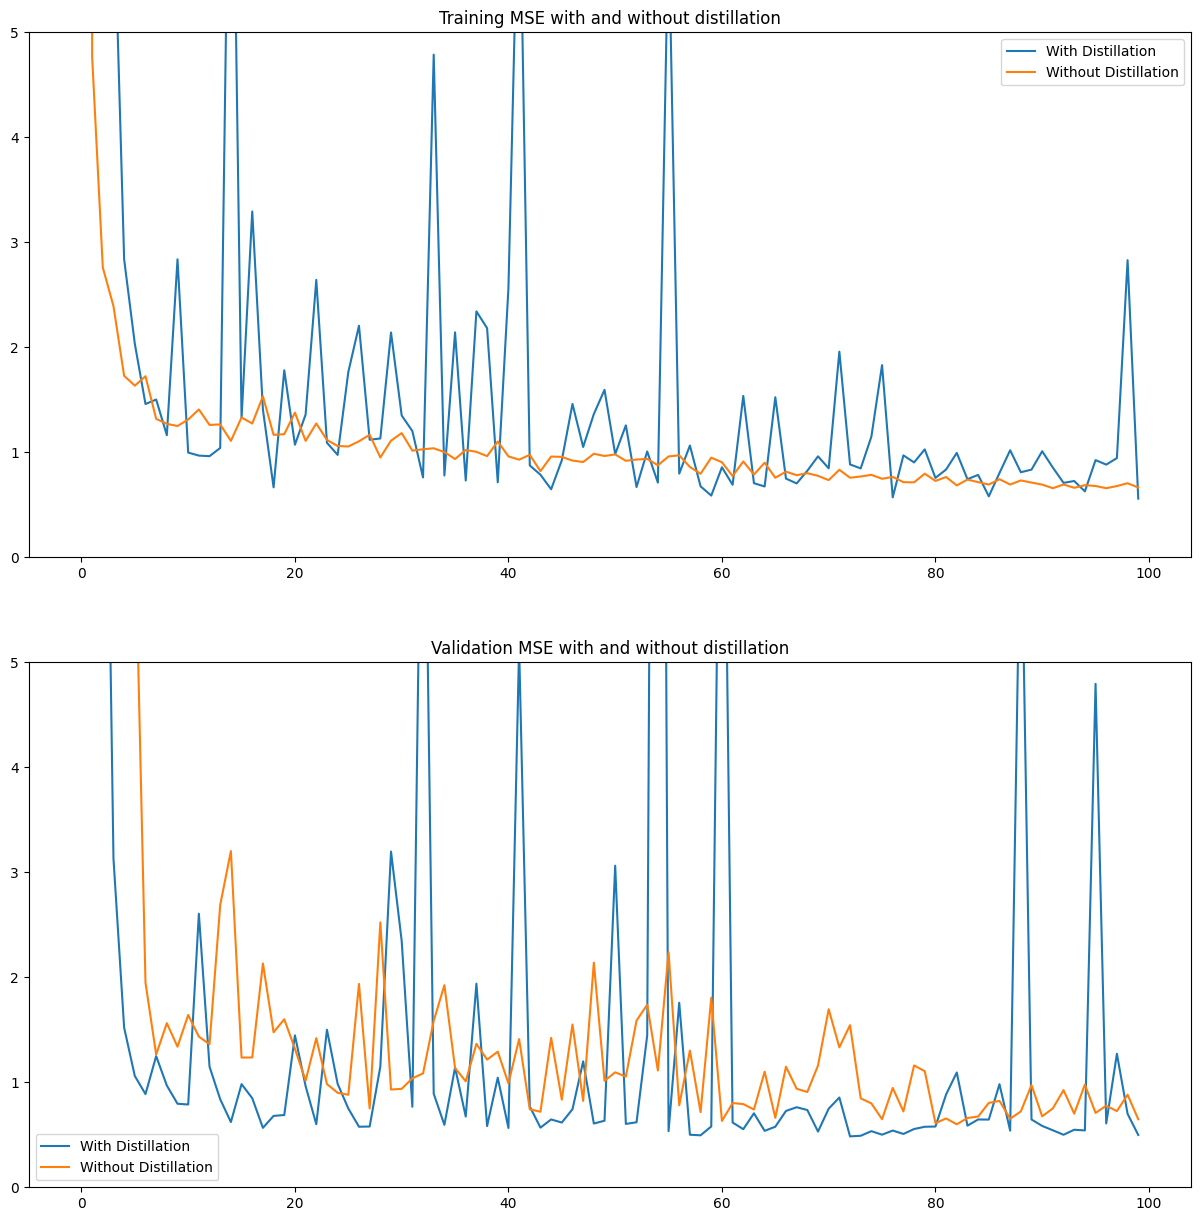

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['mse'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_mse'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_mse'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['mse'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_mse'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training MSE with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation MSE with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")
#print(f"Test mse with disstillation {test_results_with_distillation}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")
#print(f"Test mse without disstillation {test_results_without_distillation}")

Validation mse with distillation 0.5657 +- 0.2577
Validation mse without disstillation 0.5897 +- 0.0844


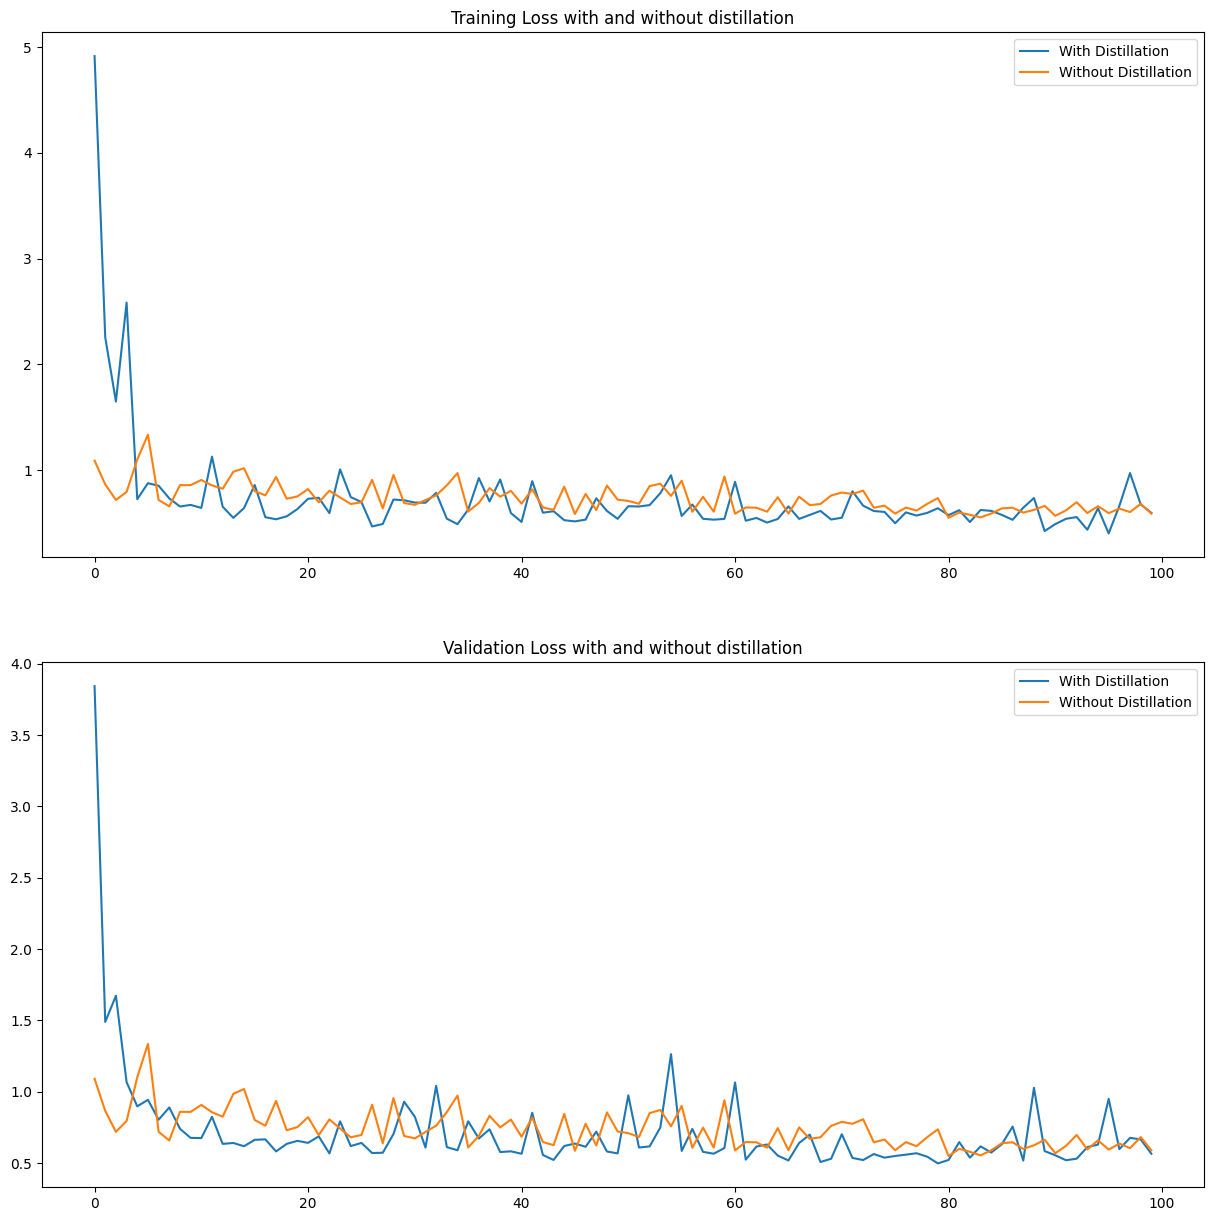

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

x = range(0, number_of_epochs)

# Compute the average on all folds for every epochs for training data
train_mse_with_distillation = np.mean([d['student_loss'] for d in train_val_results_with_distillation], 0)
train_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for the training dataset
train_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['student_loss'] for d in train_val_results_with_distillation]]
train_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['loss'] for d in train_val_results_without_distillation]]

train_with_distillation_mse_std = np.std(train_with_distillation_mse_last_epochs)
train_without_distillation_mse_std = np.std(train_without_distillation_mse_last_epochs)


# Compute the average on all folds for every epochs for validation data
val_mse_with_distillation = np.mean([d['val_student_loss'] for d in train_val_results_with_distillation], 0)
val_mse_without_distillation = np.mean([d['val_loss'] for d in train_val_results_without_distillation], 0)

# Get the MSE for valiation dataset
val_with_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_student_loss'] for d in train_val_results_with_distillation]]
val_without_distillation_mse_last_epochs = [fold[-1:] for fold in [d['val_loss'] for d in train_val_results_without_distillation]]

val_with_distillation_mse_stds = np.std(val_with_distillation_mse_last_epochs)
val_without_distillation_mse_stds = np.std(val_without_distillation_mse_last_epochs)


# Traning results
axs[0].plot(x, train_mse_with_distillation) 
axs[0].plot(x, train_mse_without_distillation) 
#axs[0].set_ylim(0, 5)
axs[0].title.set_text('Training Loss with and without distillation') 
axs[0].legend(['With Distillation', 'Without Distillation'])  

# Val results
axs[1].plot(x, val_mse_with_distillation) 
axs[1].plot(x, val_mse_without_distillation) 
#axs[1].set_ylim(0, 5)
axs[1].title.set_text('Validation Loss with and without distillation') 
axs[1].legend(['With Distillation', 'Without Distillation'])

print(f"Validation mse with distillation {np.round(np.mean(val_with_distillation_mse_last_epochs), 4)} +- {np.round(val_with_distillation_mse_stds, 4)}")

print(f"Validation mse without disstillation {np.round(np.mean(val_without_distillation_mse_last_epochs), 4)} +- {np.round(val_without_distillation_mse_stds, 4)}")

In [11]:
# Train again on the entire traning set and then test
studnet_model = buildStudentModel()
studnet_model_without_distillation = keras.models.clone_model(studnet_model)

distiller = Distiller.Distiller(student=studnet_model, teacher=teacher_model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['mse', 'mae', 'mape'],
    student_loss_fn=tf.keras.losses.MeanAbsoluteError(),
    distillation_loss_fn=distiller.mse_distillation_loss_fucntion,
    alpha=0.1,
    temperature=10        
)
# Retrain both models
distiller.fit(x_train, y_train, epochs=number_of_epochs)

studnet_model_without_distillation.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=['mse', 'mae', 'mape'],
)
studnet_model_without_distillation.fit(x_train, y_train, epochs=number_of_epochs)
    
# Evaluate the models onb the test data when the training is complete    
# Evaluate student on test dataset
test_results_with_distillation = distiller.evaluate(x_test, y_test, return_dict=True)
test_results_without_distillation = studnet_model_without_distillation.evaluate(x_test, y_test, return_dict=True)

Epoch 1/100
492/492 [==============================] - 2s 3ms/step - mse: 7207.5747 - mae: 30.5157 - mape: 2094.4417 - student_loss: 30.4140 - distillation_loss: 7180.2976
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - mse: 4.2909 - mae: 0.8191 - mape: 54.7613 - student_loss: 0.8185 - distillation_loss: 3.7811
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - mse: 2.0990 - mae: 0.7309 - mape: 49.8107 - student_loss: 0.7306 - distillation_loss: 1.6317
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9920 - mae: 0.6456 - mape: 43.7718 - student_loss: 0.6451 - distillation_loss: 0.5583
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - mse: 0.8560 - mae: 0.6403 - mape: 43.1721 - student_loss: 0.6405 - distillation_loss: 0.4212
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - mse: 0.6595 - mae: 0.5977 - mape: 39.8874 - student_loss: 0.5976 - distillation_loss: 0.2370
Epoch 7/100
492/49

492/492 [==============================] - 1s 2ms/step - mse: 0.8736 - mae: 0.6487 - mape: 42.1809 - student_loss: 0.6483 - distillation_loss: 0.4626
Epoch 52/100
492/492 [==============================] - 1s 2ms/step - mse: 1.7517 - mae: 0.8163 - mape: 53.2560 - student_loss: 0.8151 - distillation_loss: 1.3358
Epoch 53/100
492/492 [==============================] - 1s 2ms/step - mse: 0.5783 - mae: 0.5666 - mape: 36.4775 - student_loss: 0.5666 - distillation_loss: 0.1678
Epoch 54/100
492/492 [==============================] - 1s 2ms/step - mse: 0.9782 - mae: 0.7074 - mape: 45.6398 - student_loss: 0.7080 - distillation_loss: 0.5844
Epoch 55/100
492/492 [==============================] - 1s 2ms/step - mse: 1.4473 - mae: 0.7767 - mape: 50.4209 - student_loss: 0.7757 - distillation_loss: 1.0336
Epoch 56/100
492/492 [==============================] - 1s 2ms/step - mse: 1.4625 - mae: 0.6913 - mape: 44.6341 - student_loss: 0.6911 - distillation_loss: 1.0546
Epoch 57/100
492/492 [=============

492/492 [==============================] - 1s 2ms/step - loss: 5.1543 - mse: 593.0228 - mae: 5.1543 - mape: 342.4841
Epoch 2/100
492/492 [==============================] - 1s 2ms/step - loss: 0.9056 - mse: 18.4799 - mae: 0.9056 - mape: 61.5410
Epoch 3/100
492/492 [==============================] - 1s 2ms/step - loss: 0.8585 - mse: 12.3260 - mae: 0.8585 - mape: 57.4172
Epoch 4/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7750 - mse: 7.9248 - mae: 0.7750 - mape: 50.5816
Epoch 5/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7324 - mse: 5.3268 - mae: 0.7324 - mape: 47.4480
Epoch 6/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7829 - mse: 4.0895 - mae: 0.7829 - mape: 50.3125
Epoch 7/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7534 - mse: 2.6165 - mae: 0.7534 - mape: 48.2936
Epoch 8/100
492/492 [==============================] - 1s 2ms/step - loss: 0.7880 - mse: 2.3310 - mae: 0.7880 - mape: 50.4418

492/492 [==============================] - 1s 2ms/step - loss: 0.6431 - mse: 0.9097 - mae: 0.6431 - mape: 40.3633
Epoch 66/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6848 - mse: 0.9007 - mae: 0.6848 - mape: 43.1511
Epoch 67/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6228 - mse: 0.7871 - mae: 0.6228 - mape: 39.0378
Epoch 68/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6221 - mse: 0.8776 - mae: 0.6221 - mape: 38.9224
Epoch 69/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6242 - mse: 0.7404 - mae: 0.6242 - mape: 38.9897
Epoch 70/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6325 - mse: 0.7723 - mae: 0.6325 - mape: 39.3390
Epoch 71/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6289 - mse: 0.7394 - mae: 0.6289 - mape: 39.5203
Epoch 72/100
492/492 [==============================] - 1s 2ms/step - loss: 0.6526 - mse: 0.8009 - mae: 0.6526 - mape: 41.06

In [12]:
print(f"Test mse with disstillation {test_results_with_distillation}")
print(f"Test mse without disstillation {test_results_without_distillation}")

Test mse with disstillation {'mse': 0.6206130981445312, 'mae': 0.5704405903816223, 'mape': 33.26157760620117, 'student_loss': 0.5567378997802734}
Test mse without disstillation {'loss': 0.6146624088287354, 'mse': 0.7470628619194031, 'mae': 0.6146624088287354, 'mape': 32.24753189086914}


In [22]:
# # Save the model to load in future
# %mkdir Exp1Models
#%mkdir Exp1Models/Exp2

# studnet_model.save('Exp1Models/Exp2/studnet_model')
# studnet_model_without_distillation.save('Exp1Models/Exp2/studnet_model_without_distillation')

The syntax of the command is incorrect.


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets


INFO:tensorflow:Assets written to: Exp1Models/Exp2/studnet_model_without_distillation\assets
